# Density inversion
Most of *Invert4Geom's* functionality is centered on performing geometric inversions, to estimated the shape of a layer. However, we also support density inversions, where the density of each model element (prism or tesseroid) is updated to minimize the gravity misfit. To showcase this, we will create a synthetic observed gravity dataset calculated from the forward gravity of a prism layer with spatially variable density values. The topography represents the basement surface (the contact between crystalline rock and sediments). We will assume constant basement density, and use the spatially variable density values to represent the sediment density. We will then try and recover these density values during the inversion. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# set EPSG for plotting functions
import os

import polartoolkit as ptk
import verde as vd

import invert4geom

os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create synthetic basement topography and spatially variable density, and use these to calculate the gravity effect. This will be used as our observed gravity.

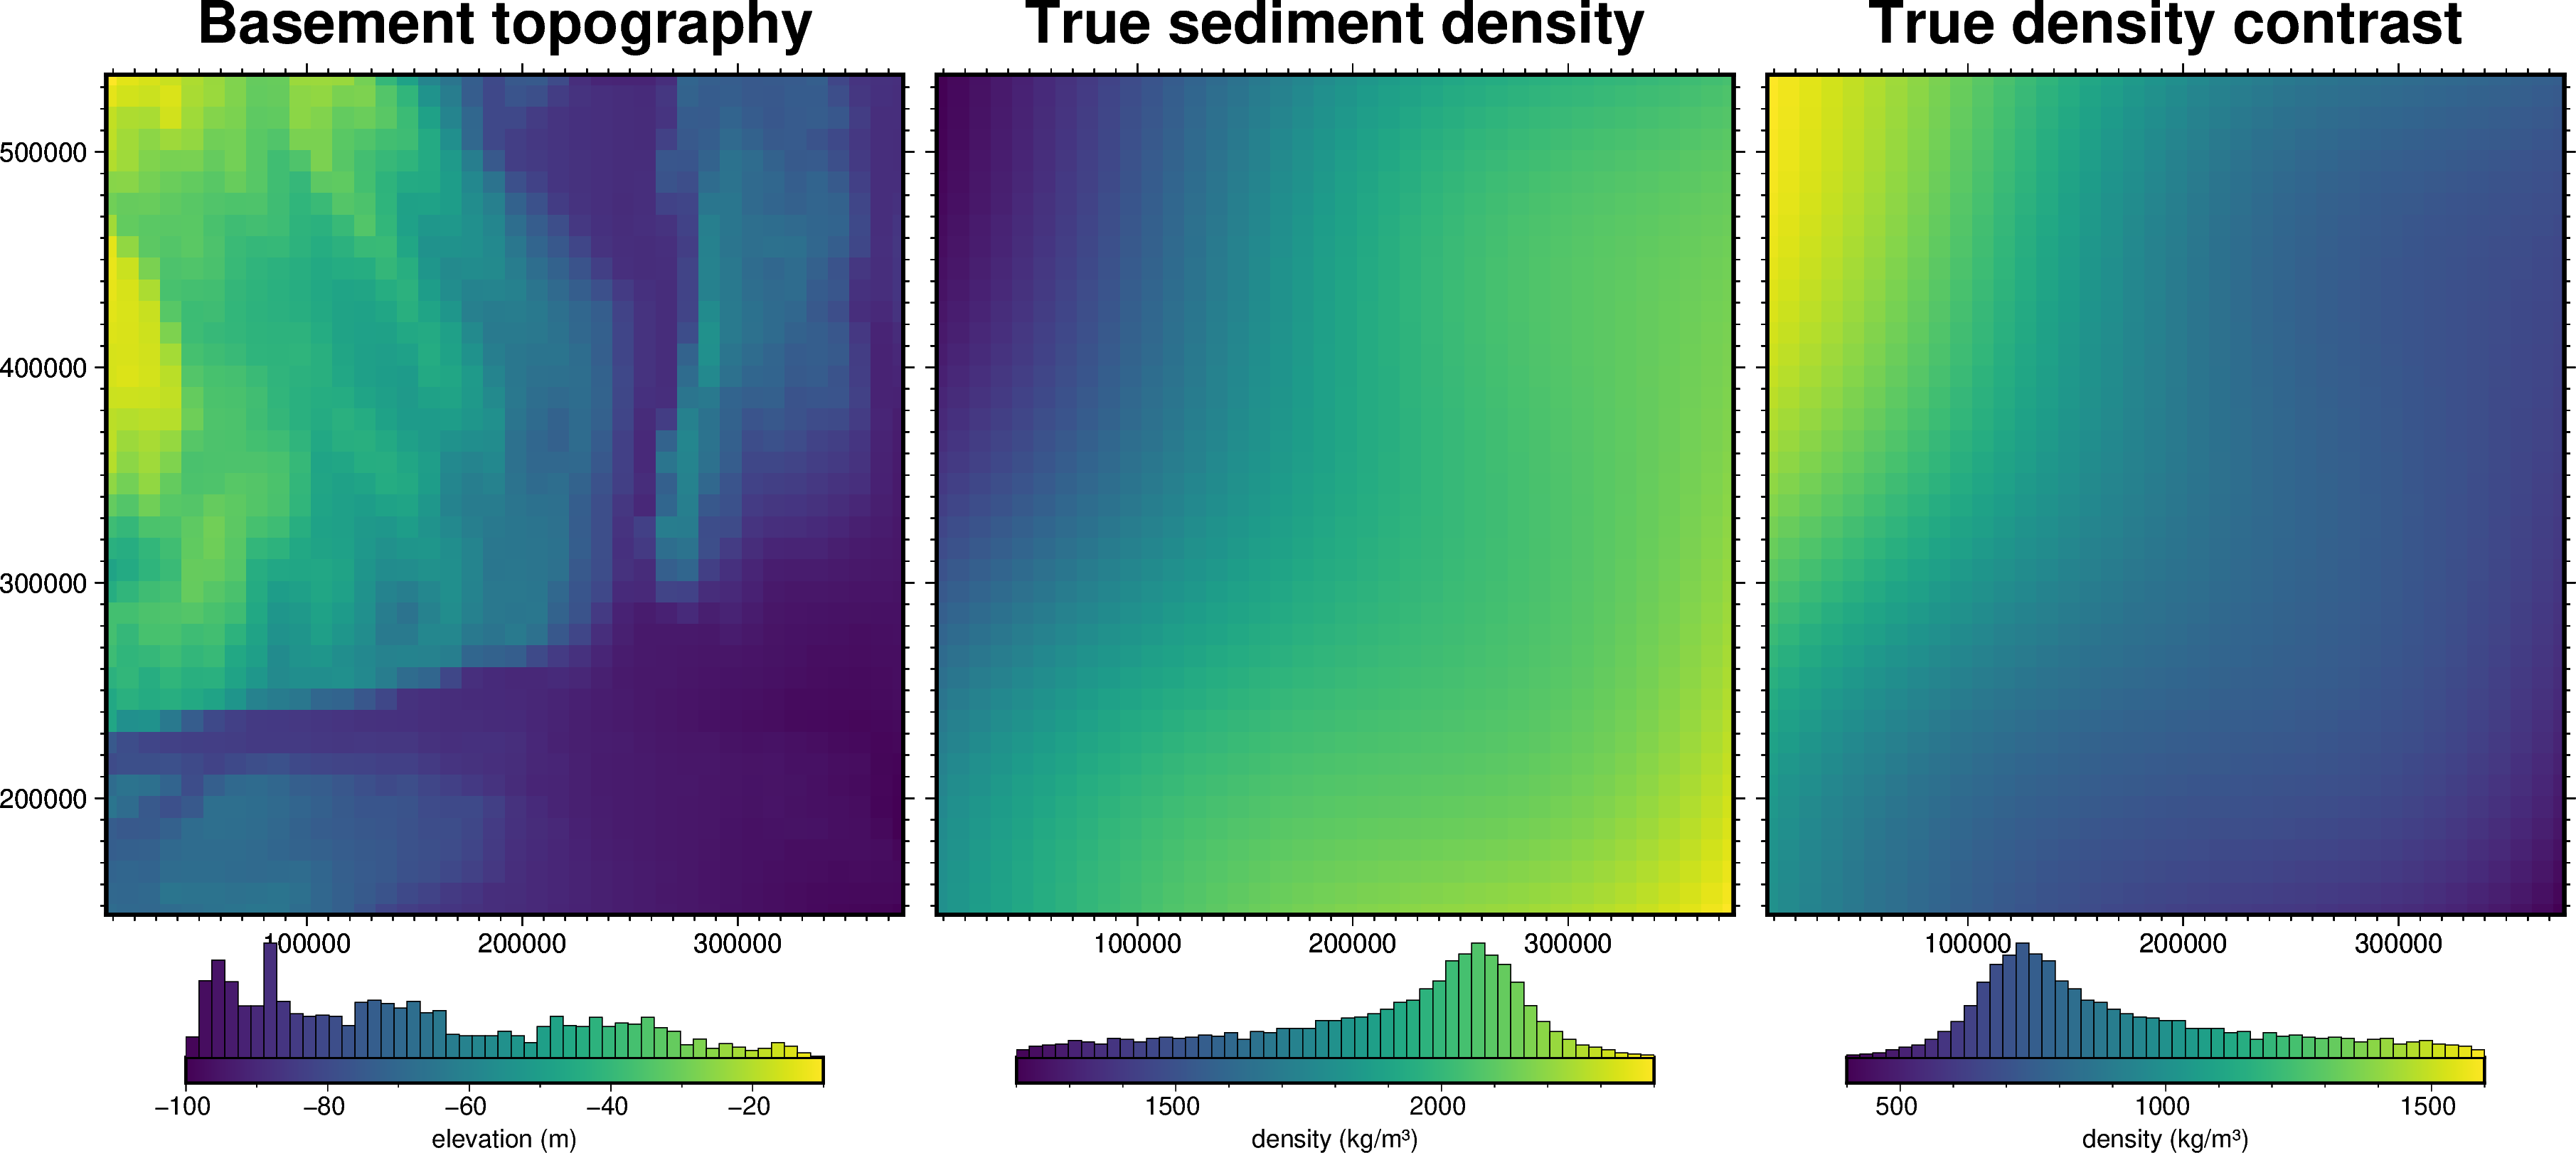

In [2]:
# load bishop model
bishop_model = invert4geom.load_bishop_model(coarsen_factor=50)

# get the basement topography
topography = invert4geom.utils.normalize_xarray(
    bishop_model.basement_topo, low=-100, high=-10
)

spacing, region, _, _, _ = ptk.get_grid_info(topography)

fig = ptk.plot_grid(
    topography,
    fig_height=10,
    title="Basement topography",
    cmap="viridis",
    hist=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

# scale between 1200 and 2400 kg/m³ to use as sediment density values
true_density = invert4geom.utils.normalize_xarray(
    bishop_model.moho_topo, low=1200, high=2400
).rename("true_sediment_density")

# calculated the density contrast between basement and sediment
true_density_contrast = 2800 - true_density  # assuming basement density is 2800

# plot the true density
fig = ptk.plot_grid(
    true_density,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True sediment density",
    cmap="viridis",
    hist=True,
    cbar_label="density (kg/m³)",
    frame=["nSwe", "xaf10000", "yaf10000"],
)

# plot the true density-contrast
fig = ptk.plot_grid(
    true_density_contrast,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True density contrast",
    cmap="viridis",
    hist=True,
    cbar_label="density (kg/m³)",
    frame=["nSwe", "xaf10000", "yaf10000"],
)
fig.show()

### Prism layer

In [3]:
model = invert4geom.create_model(
    zref=0,  # topography.values.mean(),
    density_contrast=true_density_contrast,
    topography=topography.to_dataset(name="upward"),
)

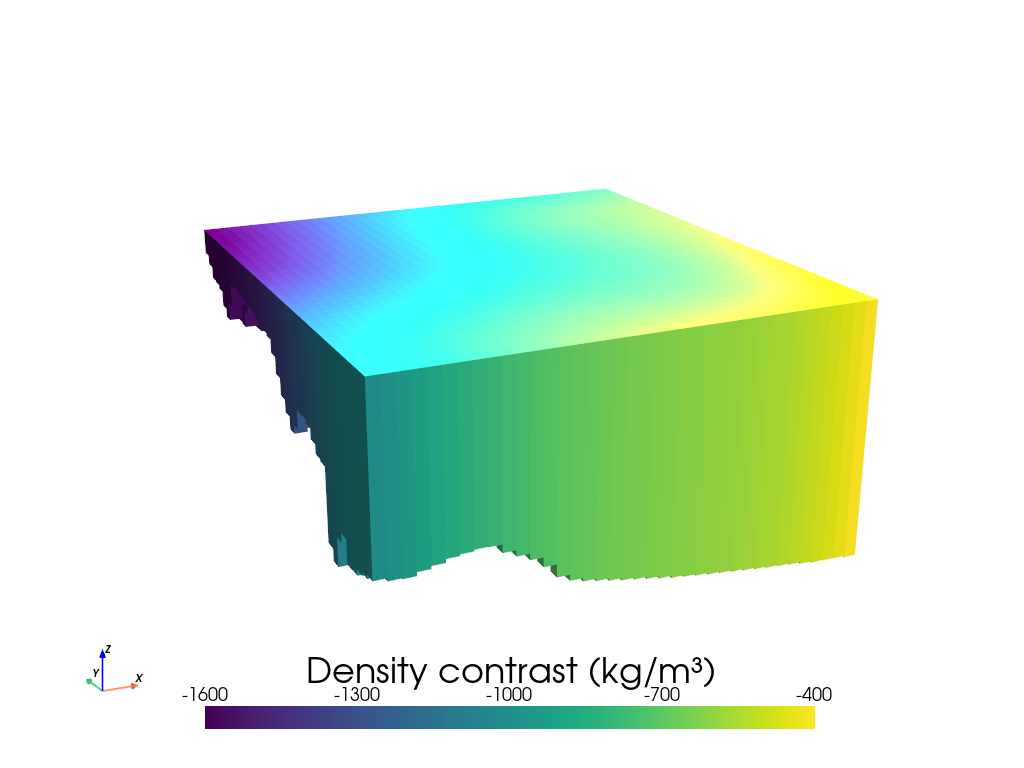

In [4]:
model.inv.plot_model(
    color_by="density",
    zscale=2000,
)

### Forward gravity of prism layer

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=100,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

grav_data.inv.forward_gravity(model, "gravity_anomaly")
grav_data

<xarray.Dataset> Size: 25kB
Dimensions:          (northing: 40, easting: 38)
Coordinates:
  * northing         (northing) float64 320B 1.459e+05 1.559e+05 ... 5.359e+05
  * easting          (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
Data variables:
    upward           (northing, easting) float64 12kB 100.0 100.0 ... 100.0
    gravity_anomaly  (northing, easting) float64 12kB -2.831 -2.798 ... -2.726
Attributes:
    region:        (6900.0, 376900.0, 145900.0, 535900.0)
    spacing:       10000.0
    buffer_width:  40000.0
    inner_region:  (46900.0, 336900.0, 185900.0, 495900.0)
    dataset_type:  data
    model_type:    prisms

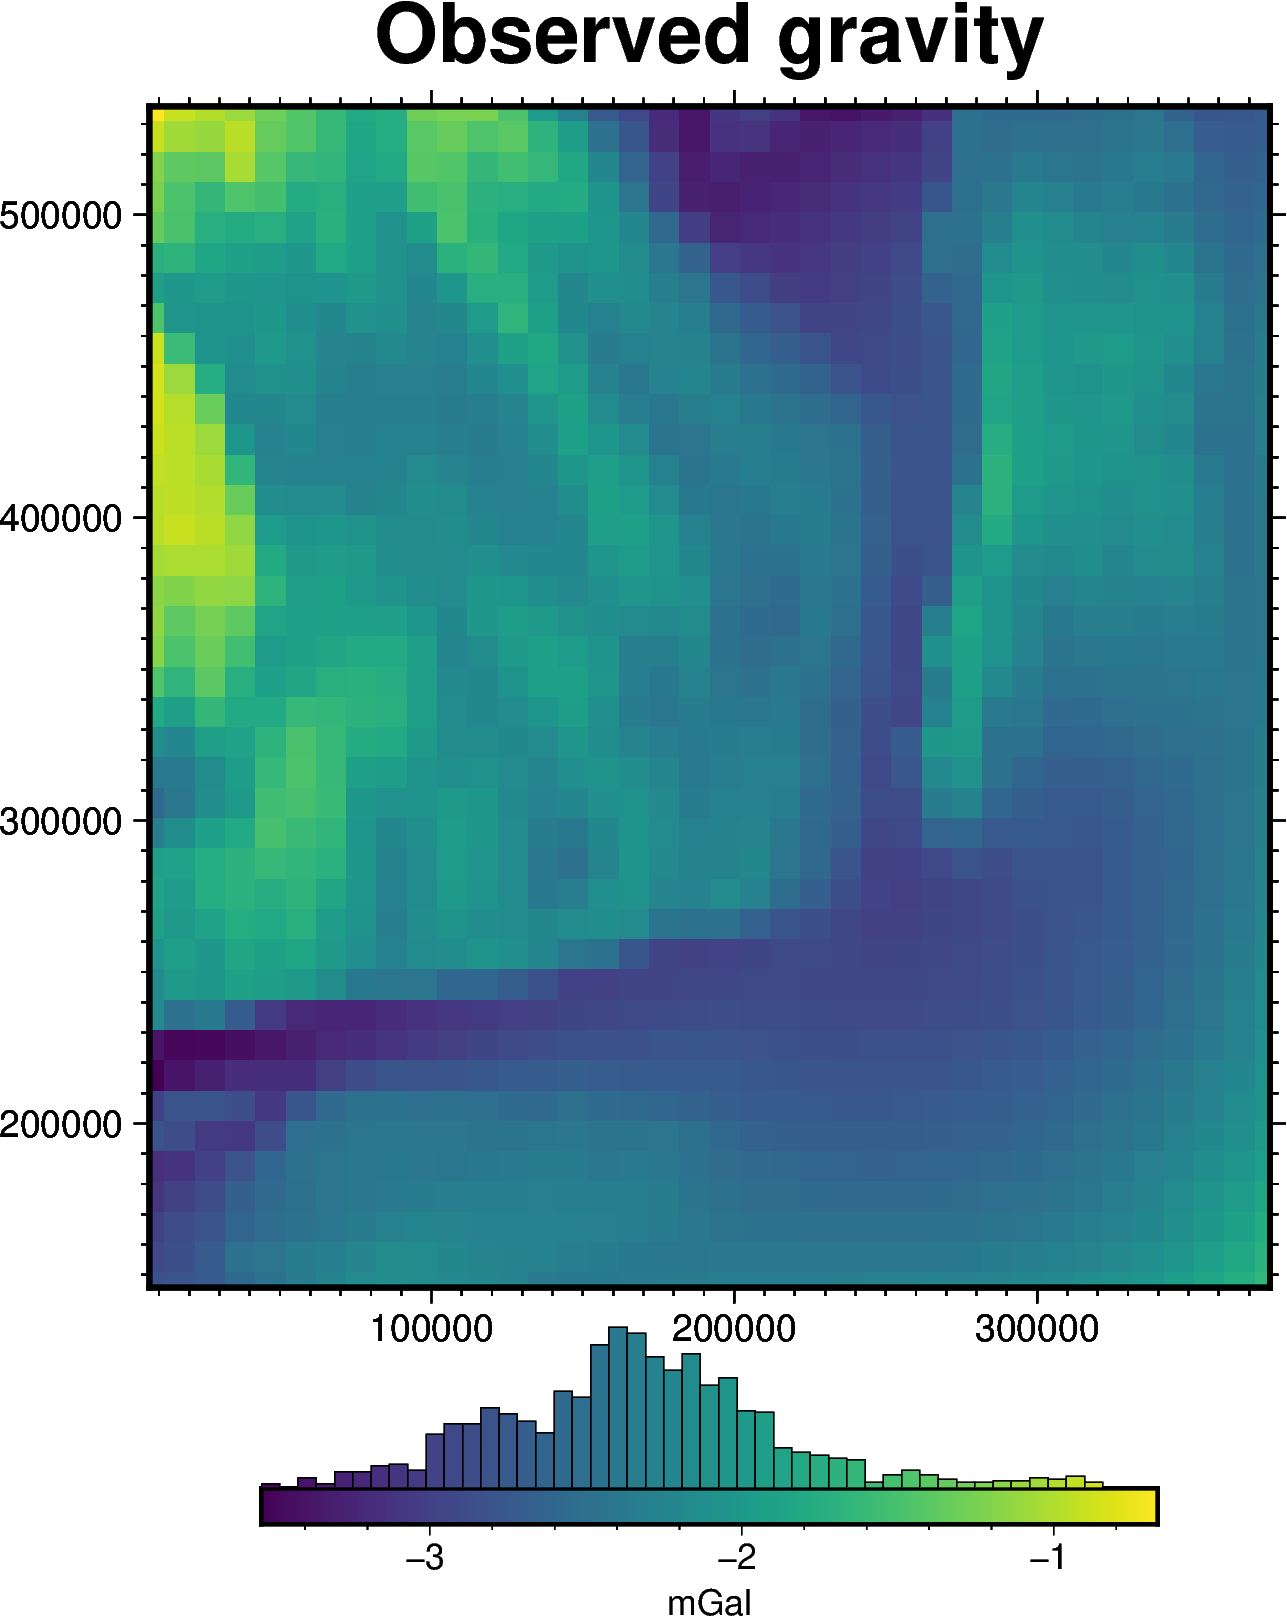

In [6]:
# plot the observed gravity
fig = ptk.plot_grid(
    grav_data.gravity_anomaly,
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model to start the inversion with. We assume we know the basement topography, but don't know the density-contrast, so just choose an reasonable value (1000 kg/m3) for the contrast between basement (2800 kg/m3) and sediment (1800 kg/m3).

In [7]:
model = invert4geom.create_model(
    zref=0,
    density_contrast=1000,
    topography=topography.to_dataset(name="upward"),
)
model

<xarray.Dataset> Size: 110kB
Dimensions:                (northing: 40, easting: 38)
Coordinates:
  * northing               (northing) float64 320B 1.459e+05 ... 5.359e+05
  * easting                (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
    top                    (northing, easting) float64 12kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 12kB -68.42 ... -87.93
Data variables:
    density                (northing, easting) int64 12kB -1000 -1000 ... -1000
    thickness              (northing, easting) float64 12kB 68.42 ... 87.93
    starting_topography    (northing, easting) float64 12kB -68.42 ... -87.93
    topography             (northing, easting) float64 12kB -68.42 ... -87.93
    mask                   (northing, easting) float64 12kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 12kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 12kB nan nan ... nan nan
Attributes:
    zref:              0
    density_contrast:  1000
    region:            (6900.0, 376900.0, 145900.0, 535900.0)
    spacing:           10000.0
    buffer_width:      0
    inner_region:      (6900.0, 376900.0, 145900.0, 535900.0)
    dataset_type:      model
    model_type:        prisms

In [8]:
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/1520 [00:00<?, ?it/s]

In [9]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data

<xarray.Dataset> Size: 122kB
Dimensions:                   (northing: 40, easting: 38)
Coordinates:
  * northing                  (northing) float64 320B 1.459e+05 ... 5.359e+05
  * easting                   (easting) float64 304B 6.9e+03 ... 3.769e+05
Data variables:
    upward                    (northing, easting) float64 12kB 100.0 ... 100.0
    gravity_anomaly           (northing, easting) float64 12kB -2.831 ... -2.726
    forward_gravity           (northing, easting) float64 12kB -2.828 ... -3.629
    misfit                    (northing, easting) float64 12kB -0.003289 ... ...
    reg                       (northing, easting) float64 12kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 12kB -0.003289 ... ...
    starting_forward_gravity  (northing, easting) float64 12kB -2.828 ... -3.629
    starting_misfit           (northing, easting) float64 12kB -0.003289 ... ...
    starting_reg              (northing, easting) float64 12kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 12kB -0.003289 ... ...
Attributes:
    region:        (6900.0, 376900.0, 145900.0, 535900.0)
    spacing:       10000.0
    buffer_width:  40000.0
    inner_region:  (46900.0, 336900.0, 185900.0, 495900.0)
    dataset_type:  data
    model_type:    prisms

makecpt [ERROR]: Option T: min >= max


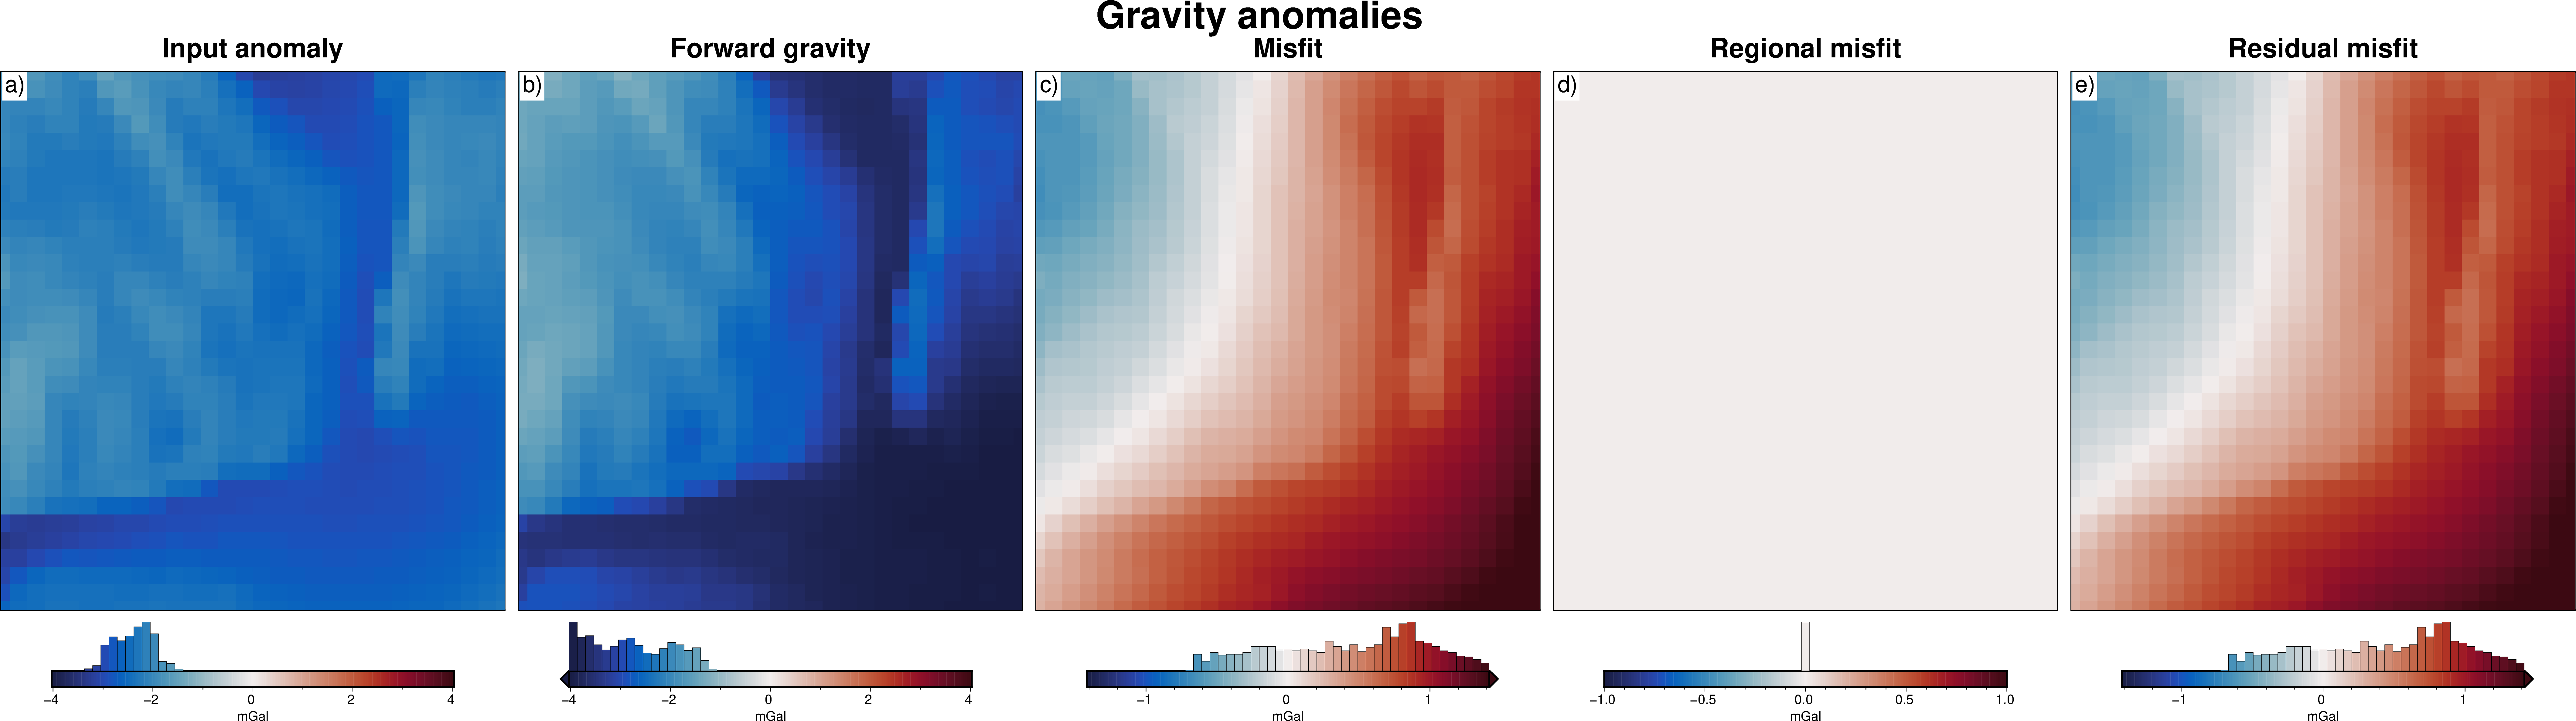

In [10]:
grav_data.inv.plot_anomalies()

## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

In [11]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    style="density",
    deriv_type="finite_difference",
    # set stopping criteria
    max_iterations=1,
)

# run the inversion
inv.invert()

Iteration: 100%|##########| 1/1 [00:00<?, ?it/s]

Inversion terminated due to max_iterations limit. Consider increasing this limit.


In [12]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,0.710278,0.84278,inf,NaN
1,1.0,0.000003,0.00164,514.013878,2.203104


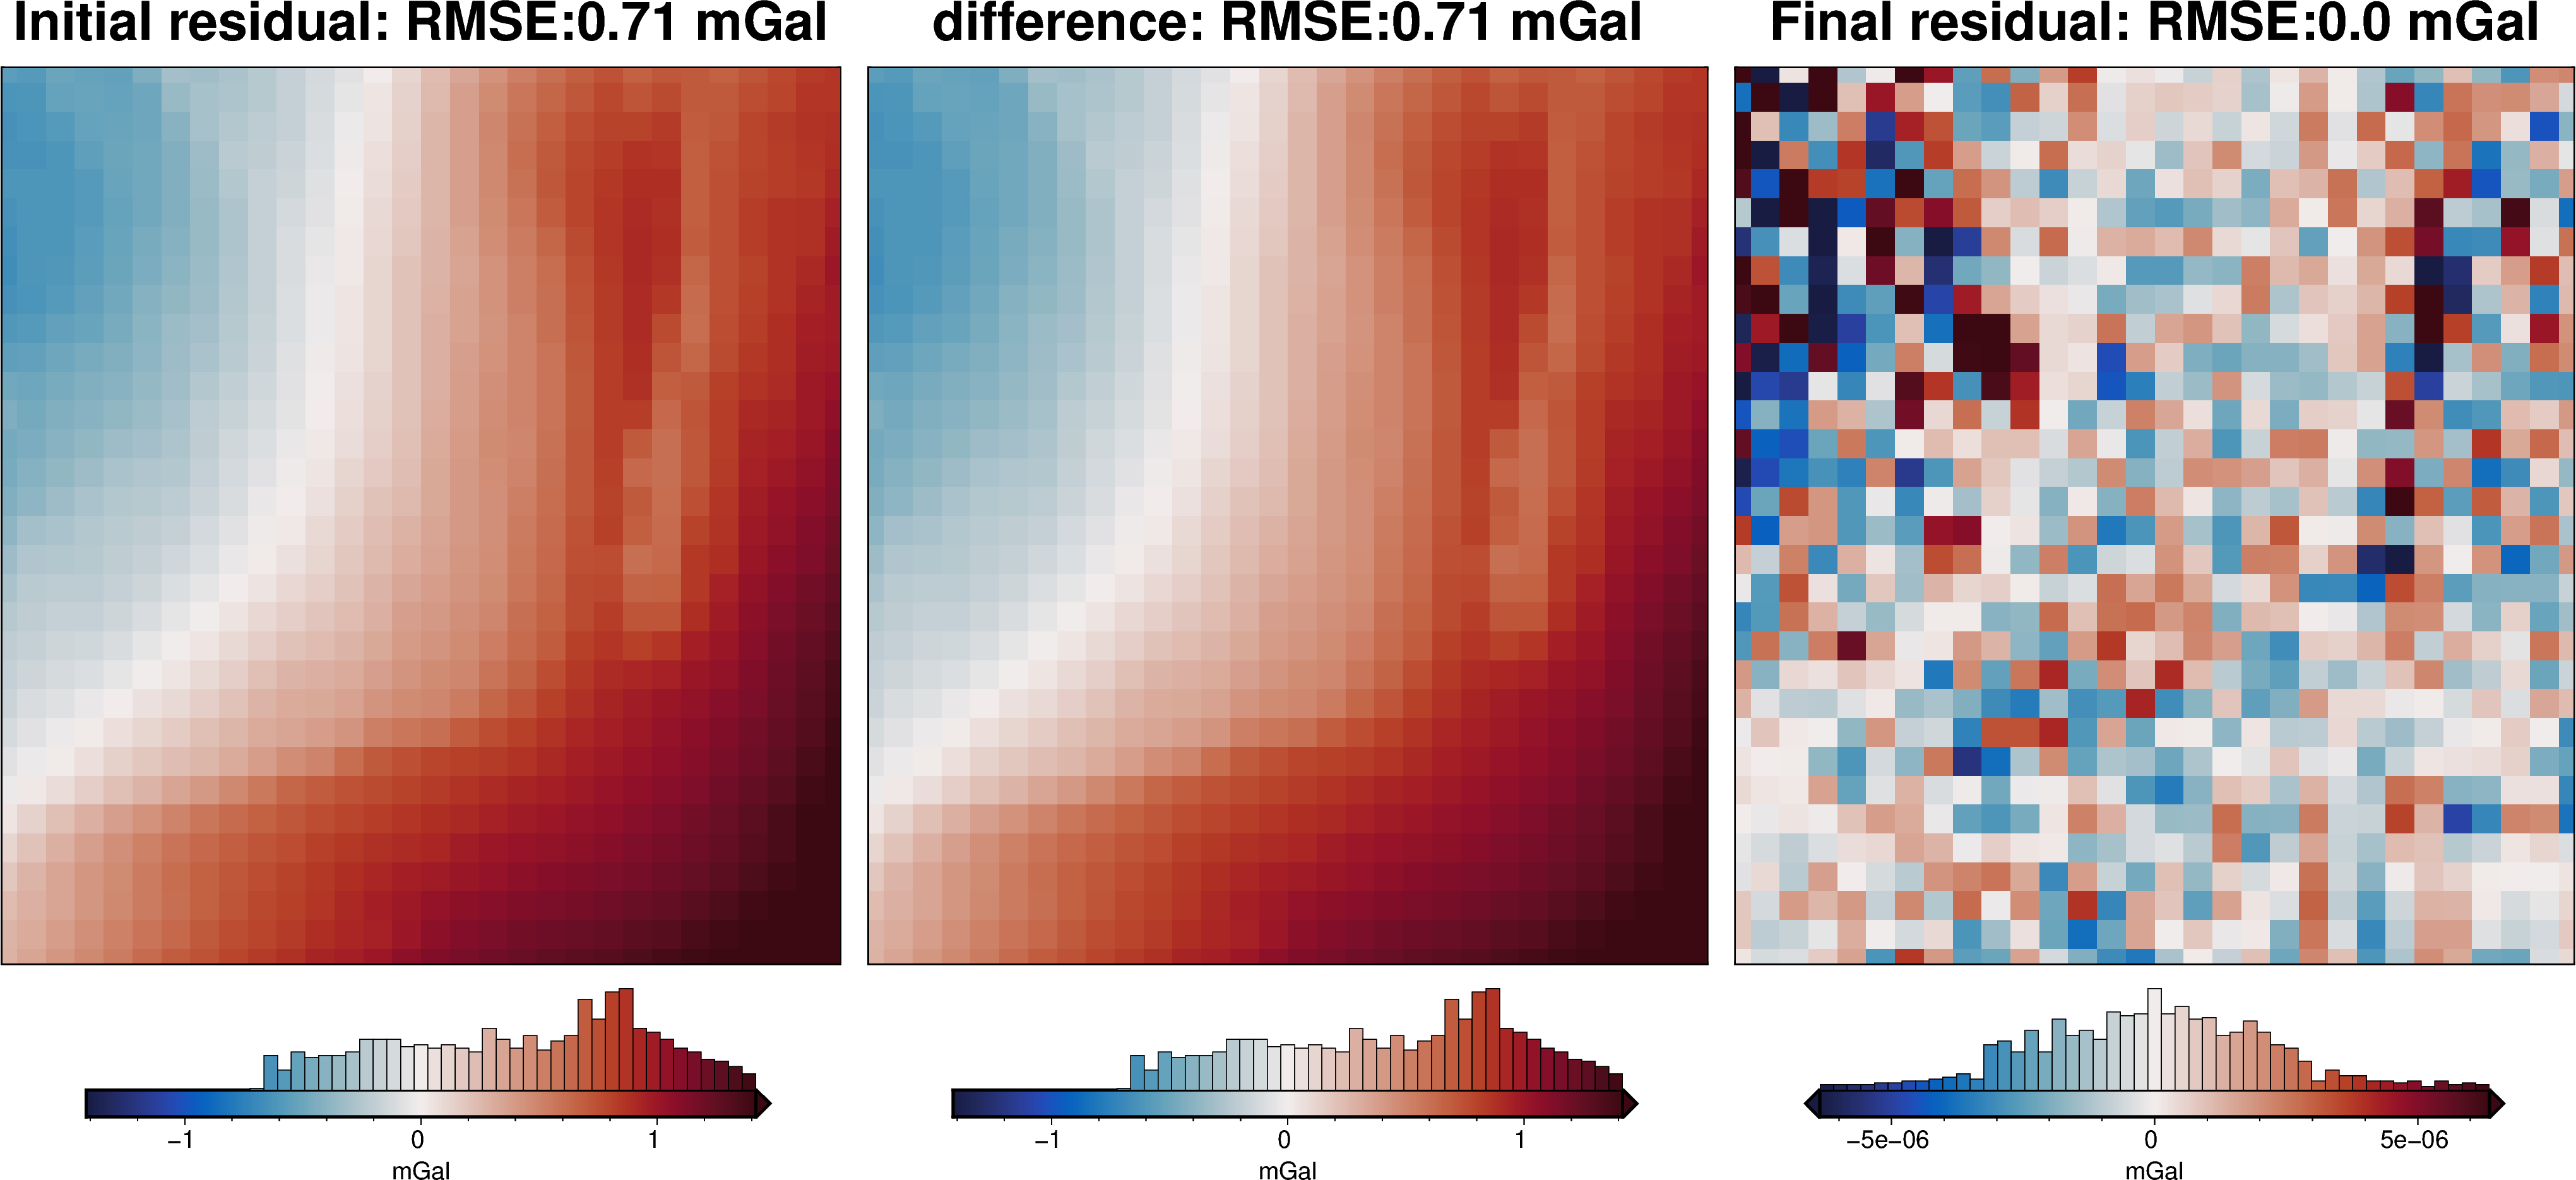

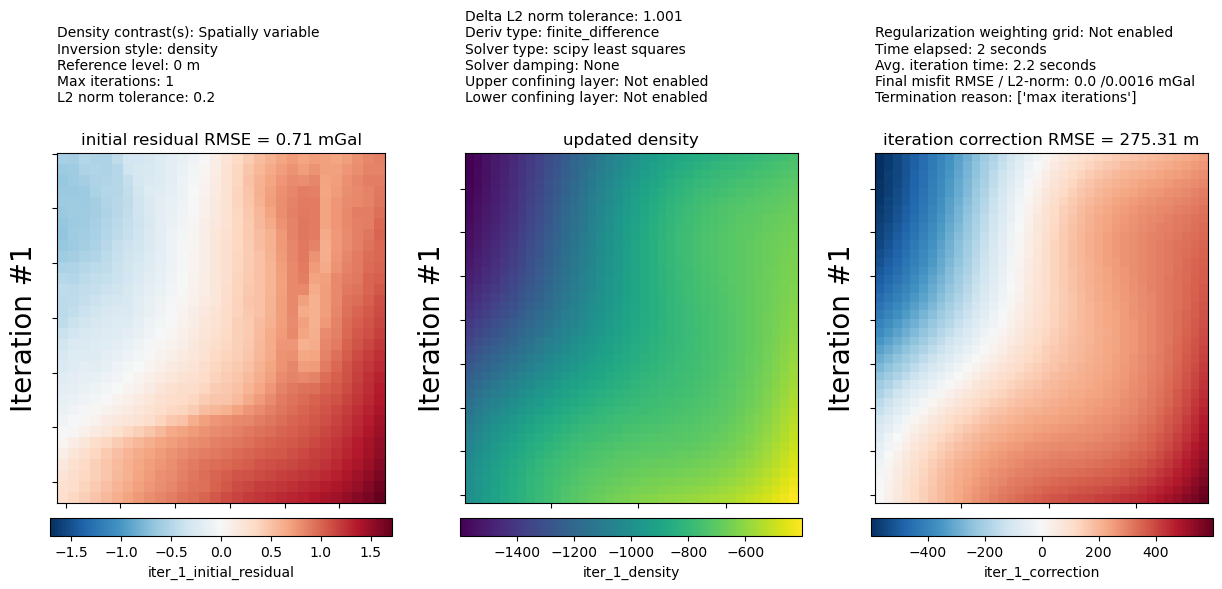

In [13]:
inv.plot_inversion_results(
    iters_to_plot=1,
)

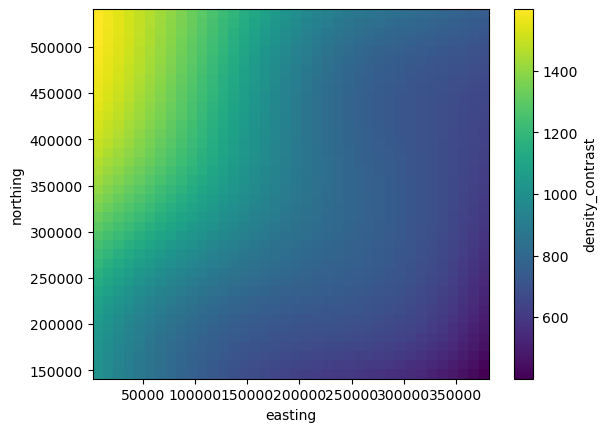

In [14]:
# the final inverted density-contrast values can be accessed from the inv.model dataset
inv.model.density_contrast.plot()

## Compare with true density and density-contrast

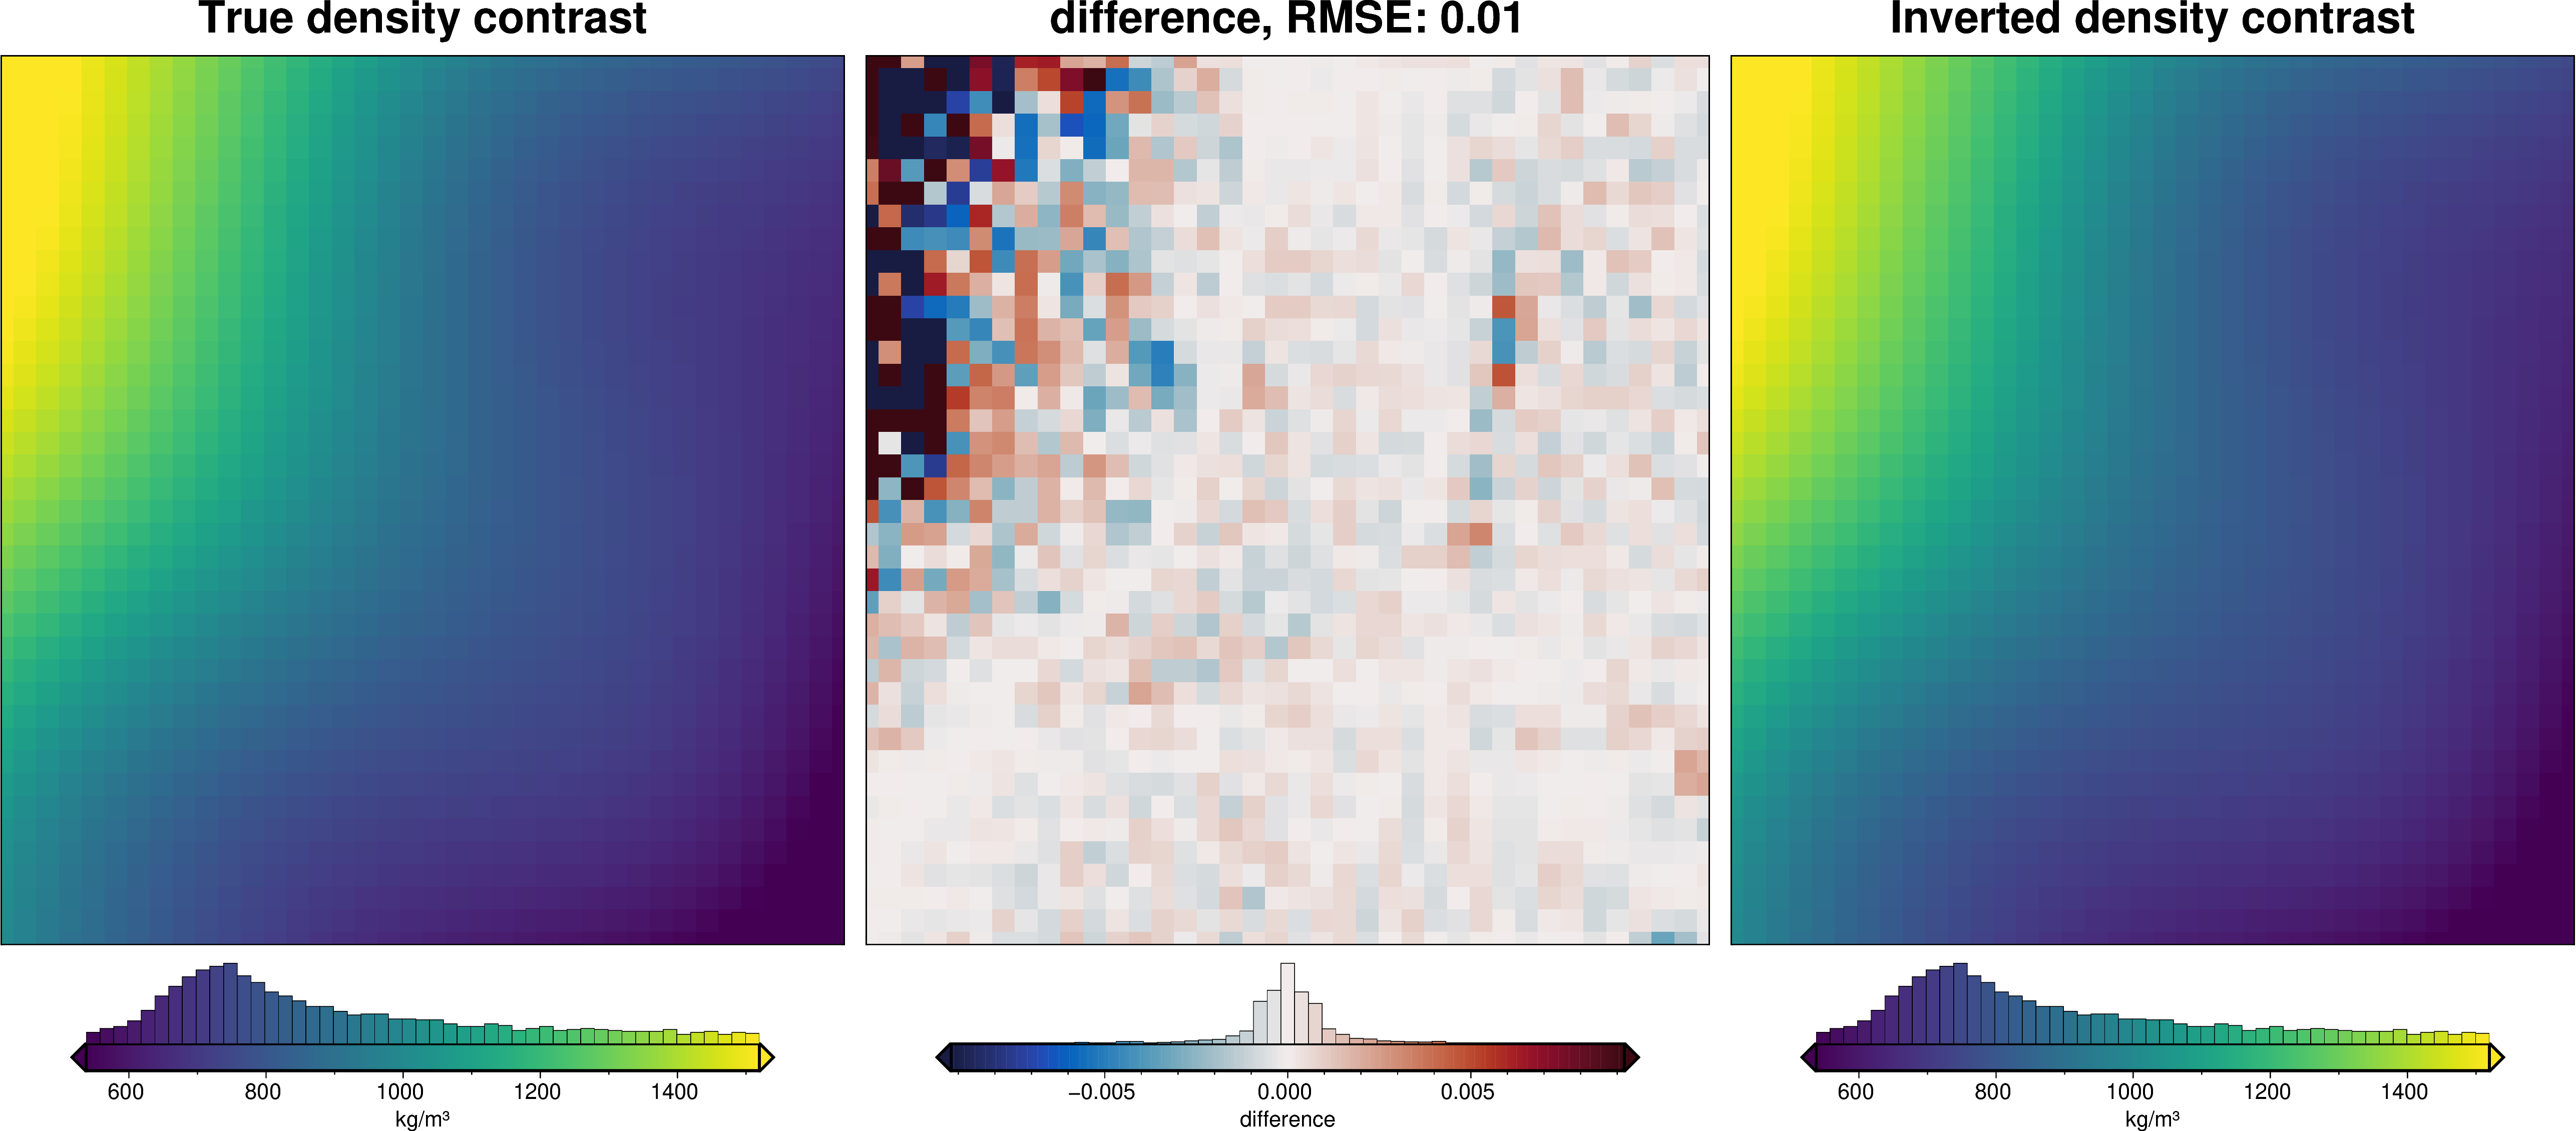

In [15]:
_ = ptk.grid_compare(
    true_density_contrast,
    inv.model.density_contrast,
    grid1_name="True density contrast",
    grid2_name="Inverted density contrast",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    cbar_label="kg/m³",
)

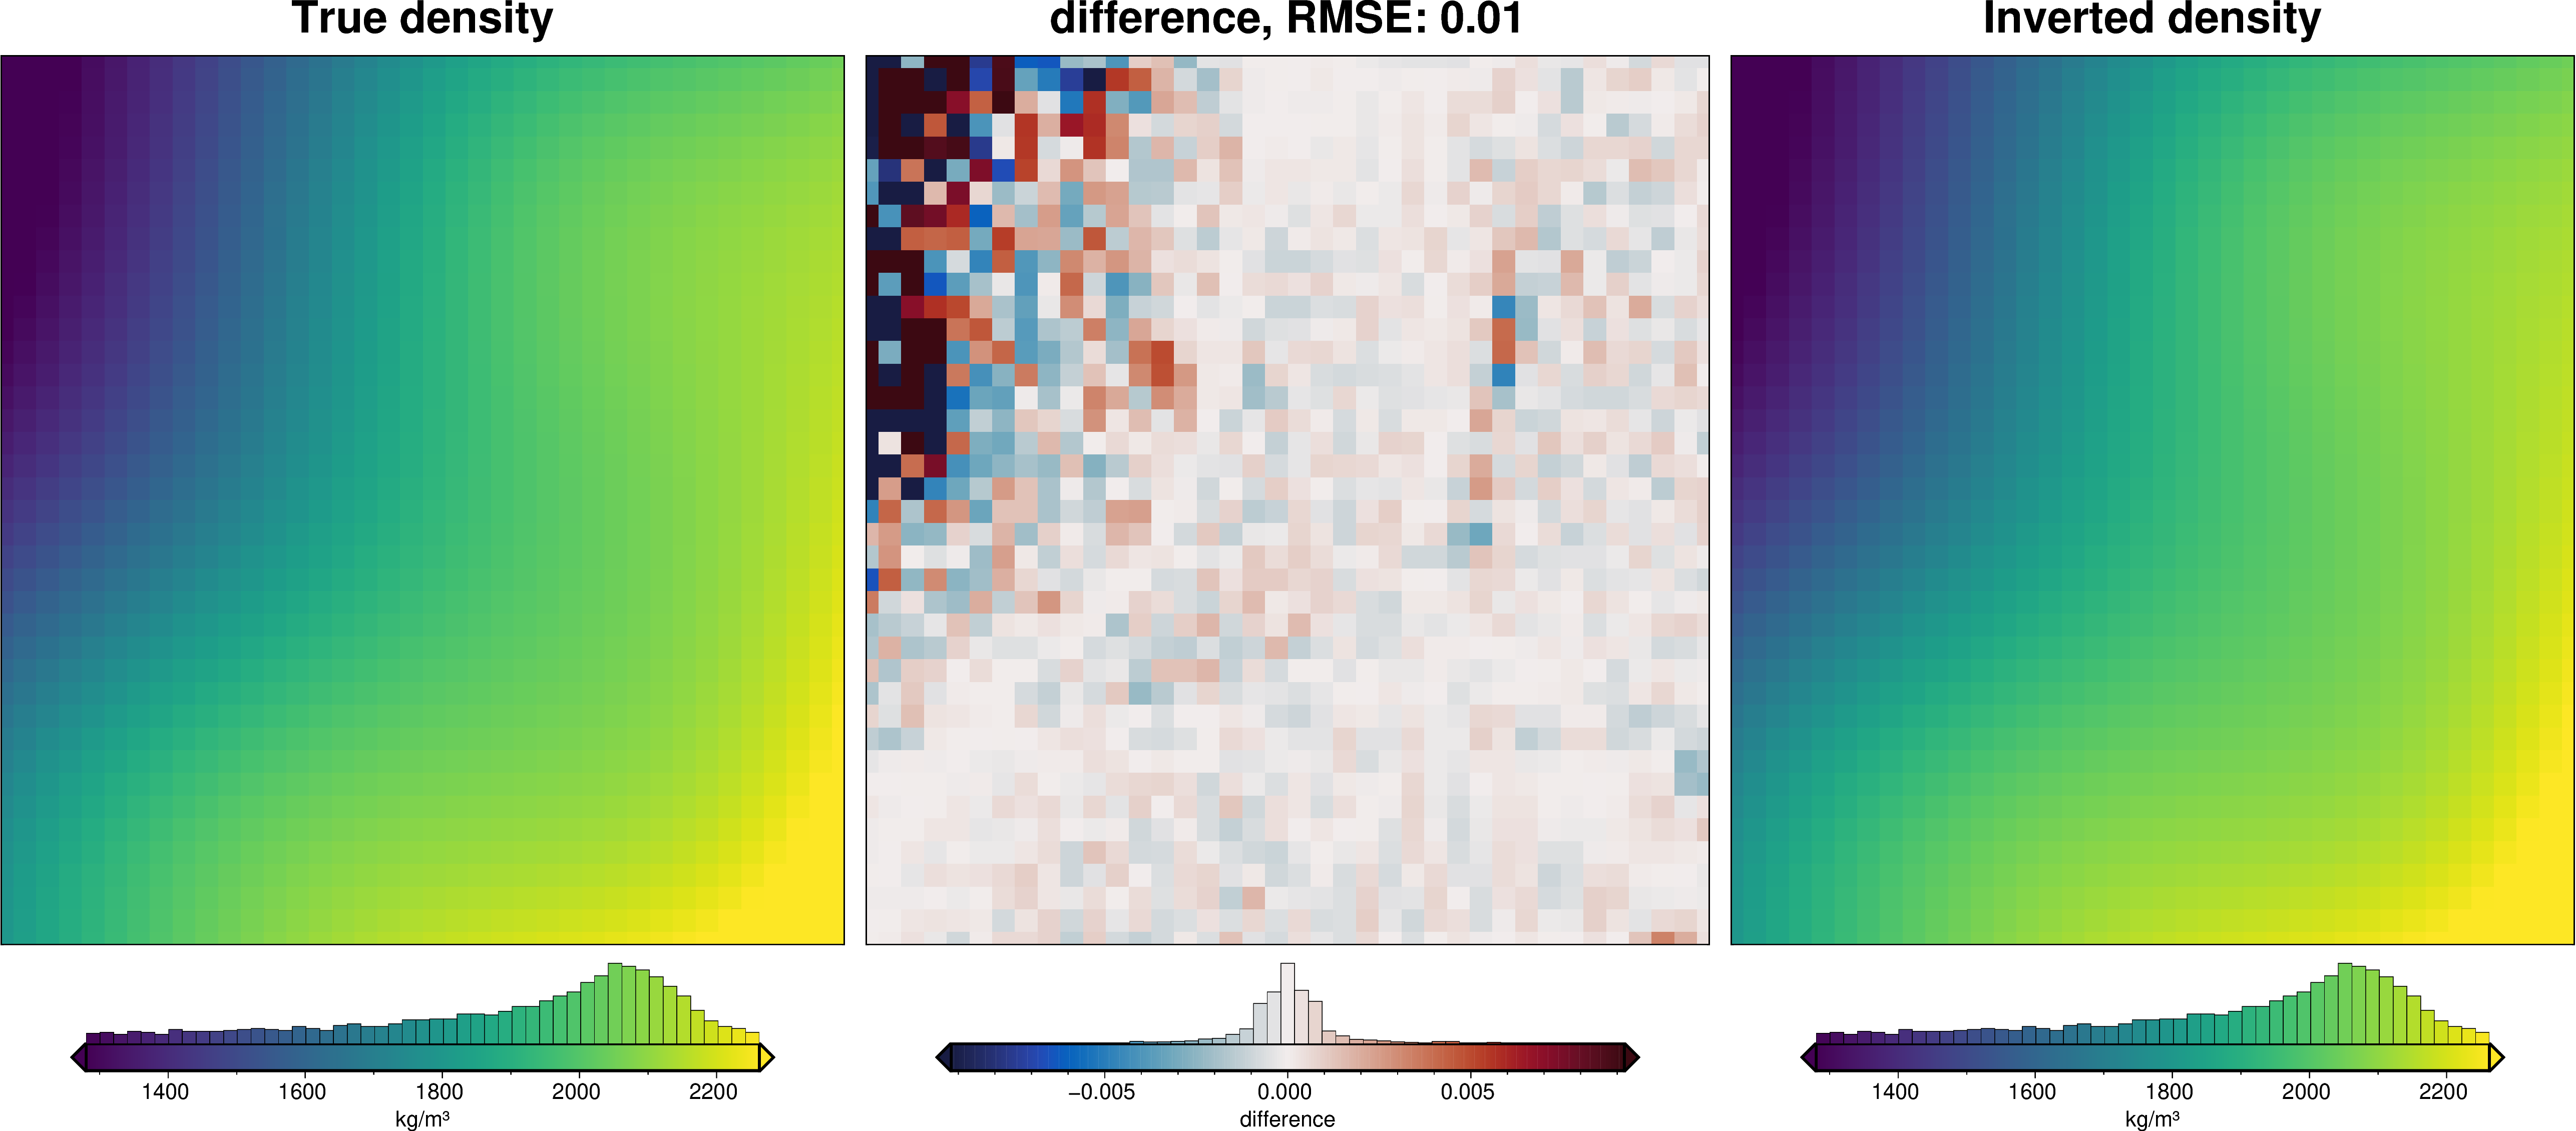

In [16]:
_ = ptk.grid_compare(
    true_density,
    # density contrast is p_basement - p_sediment
    # so to get sediment density from density contrast:
    2800 - inv.model.density_contrast,
    grid1_name="True density",
    grid2_name="Inverted density",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    cbar_label="kg/m³",
)